In [1]:
'''
Enviroment: Ubuntu 16.04 + TensorFlow 1.12.0 + cuda 9.0 + python 3.6
Dataset: Cityscapes, https://www.kaggle.com/dansbecker/cityscapes-image-pairs
Segmentation Model: UNet 
Adversarial Model: NN
Metric: Mean Intersection over Union(MIoU)=TP/(TP+FN+FP)
'''
import numpy as np
import argparse
import json
from os.path import join
import tensorflow as tf
import glob
from PIL import Image , ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow.contrib.eager as tfe
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import sys
import tempfile
from urllib.request import urlretrieve
import tarfile
import os
print(tf.VERSION) 
print(sys.version)

1.12.0
3.6.6 (default, Jun 28 2018, 04:42:43) 
[GCC 5.4.0 20160609]


In [3]:
#dataset: https://www.kaggle.com/dansbecker/cityscapes-image-pairs
def binarize( pixel ):
    if np.array_equal( pixel , [ 128, 63,127 ]):#road 
        return np.array( [ 0, 1, 0, 0, 0, 0 ] )
    elif np.array_equal( pixel , [ 70, 70, 70 ]):#building
        return np.array( [ 0, 0, 1, 0, 0, 0 ] )
    elif np.array_equal( pixel , [ 220, 20, 60 ]):#person
        return np.array( [ 0, 0, 0, 1, 0, 0 ] )
    elif np.array_equal( pixel , [ 0,  0, 142 ]):#car
        return np.array( [ 0, 0, 0, 0, 1, 0 ] )
    elif np.array_equal( pixel , [ 70,130,180 ]):#sky
        return np.array( [ 0, 0, 0, 0, 0, 1 ] )
    else :
        return np.array( [ 1, 0, 0, 0, 0, 0 ] )
#train set
def trainDataset(train_dir):
    X_train = list()
    Y_train = list()
    for filename in os.listdir( train_dir ): 
        image = Image.open(os.path.join( train_dir, filename))
        X_train.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) ) #real image
        Y_train.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) )) #labelled image
    return (np.array(X_train)/255.0).astype(np.float32), np.array(Y_train)
train_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/train'
X_train, Y_train = trainDataset(train_dir)
Y_train = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_train) ) #classify the pixel
print ('The size of feature in Train set is : {}'.format(X_train.shape))
print ('The size of label in Train set is : {}'.format(Y_train.shape))

#val set
def valDataset(val_dir):
    X_val = list()
    Y_val = list()
    for filename in os.listdir( val_dir ): 
        image = Image.open(os.path.join( val_dir, filename))
        X_val.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
        Y_val.append( np.asarray( ImageOps.crop( image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))
    return (np.array(X_val)/255.0).astype(np.float32), np.array(Y_val)
val_dir = '/data/comcode/models/research/deeplab/datasets/cityscapes/kaggle/val'
X_val,Y_val = valDataset(val_dir)
Y_val = np.apply_along_axis( binarize , axis=3 , arr=np.array(Y_val) ) #classify the pixel
print ('The size of feature in Val set is: {}'.format(X_val.shape))
print ('The size of label in Val set is : {}'.format(Y_val.shape))

The size of feature in Train set is : (2975, 128, 128, 3)
The size of label in Train set is : (2975, 128, 128, 6)
The size of feature in Val set is: (500, 128, 128, 3)
The size of label in Val set is : (500, 128, 128, 6)


In [5]:
#construct model 
class unet_seg:
    def __init__(self, lr=0.001):
        #global parameters
        self.lr = lr
        #set network structure
        self.add_placeholders()
        self.add_weight()
        self.add_model()
        self.add_loss()
        self.add_optimizer()
        self.init_sess()
        
    def add_placeholders(self):    
        self.X_input = tf.placeholder(tf.float32)
        self.Y_input = tf.placeholder(tf.float32)
    
    def add_weight(self):
        initializer = tf.initializers.glorot_uniform()
        def get_weight( shape , name ):
            return tf.Variable( initializer( shape ) , name=name , trainable=True )

        shapes = [ [ 3 , 3 , 3 , 16 ] ,   [ 3 , 3 , 16 , 16 ] , 
                   [ 3 , 3 , 16 , 32 ] ,  [ 3 , 3 , 32 , 32 ] ,
                   [ 3 , 3 , 32 , 64 ] ,  [ 3 , 3 , 64 , 64 ] ,
                   [ 3 , 3 , 64 , 128 ] , [ 3 , 3 , 128 , 128 ] ,
                   [ 3 , 3 , 128 , 256 ] ,[ 3 , 3 , 256 , 256 ] ,
                   [ 3 , 3 , 128 , 384 ], [ 3 , 3 , 128 , 128 ],
                   [ 3 , 3 , 64 , 192 ],  [ 3 , 3 , 64 , 64 ],
                   [ 3 , 3 , 32 , 96 ],   [ 3 , 3 , 32 , 32 ],
                   [ 3 , 3 , 16 , 48 ],   [ 3 , 3 , 16 , 16 ],
                   [ 1 , 1 , 16 , 6 ] #[ 1 , 1 , 16 , 1 ] 
                 ]
        weights = []
        for i in range( len( shapes ) ):
            weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )
        self.weights = weights
        
    def add_model(self):
        def conv2d_down( inputs , filters , stride_size ):
            #print( 'conv2d down' )
            out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_down( inputs , pool_size , stride_size ):
            #print( 'maxpool down' )
            return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

        def conv2d_up( inputs , filters , stride_size , output_shape ):
            #print( 'conv2d up' )
            out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding='SAME' ) 
            return tf.nn.leaky_relu( out , alpha=0.2 ) 

        def maxpool_up( inputs , size ):
            #print( 'maxpool up' )
            in_dimen = tf.shape( inputs )[ 1 ]
            out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
            return tf.image.resize_images( inputs , [ out_dimen , out_dimen ] , method=1 )#nearest
        #forward
        x = tf.cast(self.X_input , dtype=tf.float32 )
        batch_size = tf.shape( x )[0]
        c1 = conv2d_down( x , self.weights[ 0 ] , stride_size=[1,1,1,1] ) 
        c1 = conv2d_down( c1 , self.weights[ 1 ] , stride_size=[1,1,1,1] ) 
        p1 = maxpool_down( c1 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c2 = conv2d_down( p1 , self.weights[ 2 ] , stride_size=[1,1,1,1] )
        c2 = conv2d_down( c2 , self.weights[ 3 ] , stride_size=[1,1,1,1] ) 
        p2 = maxpool_down( c2 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c3 = conv2d_down( p2 , self.weights[ 4 ] , stride_size=[1,1,1,1] ) 
        c3 = conv2d_down( c3 , self.weights[ 5 ] , stride_size=[1,1,1,1] ) 
        p3 = maxpool_down( c3 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c4 = conv2d_down( p3 , self.weights[ 6 ] , stride_size=[1,1,1,1] )
        c4 = conv2d_down( c4 , self.weights[ 7 ] , stride_size=[1,1,1,1] )
        p4 = maxpool_down( c4 , pool_size=[1,2,2,1] , stride_size=[1,2,2,1] )

        c5 = conv2d_down( p4 , self.weights[ 8 ] , stride_size=[1,1,1,1] )
        c5 = conv2d_down( c5 , self.weights[ 9 ] , stride_size=[1,1,1,1] )   

        p5 = maxpool_up( c5 , 2 )
        concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
        c6 = conv2d_up( concat_1 , self.weights[ 10 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )
        c6 = conv2d_up( c6 , self.weights[ 11 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 16 , 16 , 128 ] )  

        p6 = maxpool_up( c6 , 2 )
        concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
        c7 = conv2d_up( concat_2 , self.weights[ 12 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )
        c7 = conv2d_up( c7 , self.weights[ 13 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 32 , 32 , 64 ] )  

        p7 = maxpool_up( c7 , 2 )
        concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
        c8 = conv2d_up( concat_3 , self.weights[ 14 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )
        c8 = conv2d_up( c8 , self.weights[ 15 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 64 , 64 , 32 ] )   

        p8 = maxpool_up( c8 , 2 )
        concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
        c9 = conv2d_up( concat_4 , self.weights[ 16 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )
        c9 = conv2d_up( c9 , self.weights[ 17 ] , stride_size=[1,1,1,1] , output_shape=[ batch_size , 128 , 128 , 16 ] )  

        output = tf.nn.conv2d( c9 , self.weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding='SAME' ) 
        self.Y_output = output
    
    def add_loss(self):
        #self.loss = tf.losses.sigmoid_cross_entropy( self.Y_input , self.Y_output ) 
        _loss = tf.nn.softmax_cross_entropy_with_logits( labels=self.Y_input , logits =self.Y_output ) 
        self.loss = tf.reduce_mean(_loss)
    
    def add_optimizer(self):
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_step = optimizer.minimize(self.loss)
        
    def init_sess(self):
        self.config = tf.ConfigProto()
        self.config.gpu_options.allow_growth = True
        self.config.allow_soft_placement = True
        self.sess = tf.Session(config=self.config)
        self.sess.run(tf.global_variables_initializer())
#define model
tf_model = unet_seg()

In [6]:
#train model
verbose = 10
batchSize=256
num_batches = X_train.shape[0] // batchSize + 1 
for epoch in range(10):
    losses = []
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([X_train.shape[0], (i+1)*batchSize])
        X_batch = X_train[min_idx: max_idx]
        Y_batch = Y_train[min_idx: max_idx]
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                         feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch})
        losses.append(tmp_loss)
        if verbose and i % verbose == 0:
            sys.stdout.write('\r{} / {} : loss = {}'.format(i, num_batches, np.mean(losses[-verbose:])))
            sys.stdout.flush()
    print("\nMean loss in this epoch is: {}".format(np.mean(losses)))

10 / 12 : loss = 1.6914749145507812
Mean loss in this epoch is: 1.695448875427246
10 / 12 : loss = 1.235508680343628
Mean loss in this epoch is: 1.247457504272461
10 / 12 : loss = 1.104339599609375
Mean loss in this epoch is: 1.109276294708252
10 / 12 : loss = 1.0344734191894531
Mean loss in this epoch is: 1.0324409008026123
10 / 12 : loss = 0.9598479270935059
Mean loss in this epoch is: 0.9537271857261658
10 / 12 : loss = 0.8547278642654419
Mean loss in this epoch is: 0.8530996441841125
10 / 12 : loss = 0.7299000024795532
Mean loss in this epoch is: 0.730963945388794
10 / 12 : loss = 0.6569352149963379
Mean loss in this epoch is: 0.6505210995674133
10 / 12 : loss = 0.5851715803146362
Mean loss in this epoch is: 0.5865017771720886
10 / 12 : loss = 0.5625677704811096
Mean loss in this epoch is: 0.5612922310829163


In [7]:
#verbose = 10
batchSize=256
num_batches = X_train.shape[0] // batchSize + 1 
pre_loss = 0.0
while True:#convergence
    losses = []
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([X_train.shape[0], (i+1)*batchSize])
        X_batch = X_train[min_idx: max_idx]
        Y_batch = Y_train[min_idx: max_idx]
        _, tmp_loss = tf_model.sess.run([tf_model.train_step, tf_model.loss], 
                                         feed_dict={tf_model.X_input: X_batch,tf_model.Y_input: Y_batch})
        losses.append(tmp_loss)
        #if verbose and i % verbose == 0:
        #    sys.stdout.write('\r{} / {} : loss = {}'.format(i, num_batches, np.mean(losses[-verbose:])))
        #    sys.stdout.flush()
    sys.stdout.write("\nMean loss in this epoch is: {}".format( np.mean(losses) ))
    sys.stdout.flush()
    #whether convergence
    if abs( np.mean(losses) - pre_loss)<0.001:
        break
    else:
        pre_loss = np.mean(losses)


Mean loss in this epoch is: 0.5337921977043152
Mean loss in this epoch is: 0.5152949094772339
Mean loss in this epoch is: 0.5323303937911987
Mean loss in this epoch is: 0.49702587723731995
Mean loss in this epoch is: 0.48364171385765076
Mean loss in this epoch is: 0.4600571393966675
Mean loss in this epoch is: 0.4375041425228119
Mean loss in this epoch is: 0.4208469092845917
Mean loss in this epoch is: 0.42028823494911194

In [8]:
#performance of real val
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: X_val,tf_model.Y_input: Y_val}) #prediction
Y_pred = tf_model.sess.run(tf.nn.softmax(Y_pred)) #turn to softmax
mIoUs = []
intersection = []
union = []
for i in range(len(Y_val)):
    a = Y_pred[i]
    a_one_hot = tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[2])#turn softmax to onehot 
    a = tf_model.sess.run(a_one_hot).astype(int)
    b = Y_val[i]
    intersection=np.logical_and(a.flatten(),b.flatten())
    union=np.logical_or(a.flatten(),b.flatten())
    iou_score = np.sum(intersection) / np.sum(union)
    mIoUs.append(iou_score)
    sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), iou_score))
    sys.stdout.flush()
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

499 / 500 : IoU = 0.82857142857142864===> mIoU: 69.91


In [11]:
#generate adversarial samples of val
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()
x_hat = tf.Variable(tf.zeros((128, 128, 3)))
x = tf.placeholder(tf.float32, (128, 128, 3))
assign_op = tf.assign(x_hat, x)
demo_epsilon = 2.0/255.0 
epsilon = tf.placeholder(tf.float32, ())
below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)
#load val images
X_val_ad = []
for i in range(len(X_val)):
    img = X_val[i]
    #initializer
    sess.run(assign_op, feed_dict={x: img})
    #make small perturbation  
    x_hat_ad = sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    X_val_ad.append(x_hat_ad)

In [12]:
#performance of adversarial val
Y_pred = tf_model.sess.run(tf_model.Y_output, feed_dict={tf_model.X_input: np.array(X_val_ad),tf_model.Y_input: Y_val}) #prediction
Y_pred = tf_model.sess.run(tf.nn.softmax(Y_pred)) #turn to softmax
mIoUs = []
intersection = []
union = []
for i in range(len(Y_val)):
    a = Y_pred[i]
    a_one_hot = tf.one_hot(tf.nn.top_k(a).indices, tf.shape(a)[2])#turn softmax to onehot 
    a = tf_model.sess.run(a_one_hot).astype(int)
    b = Y_val[i]
    intersection=np.logical_and(a.flatten(),b.flatten())
    union=np.logical_or(a.flatten(),b.flatten())
    iou_score = np.sum(intersection) / np.sum(union)
    mIoUs.append(iou_score)
    sys.stdout.write('\r{} / {} : IoU = {}'.format(i, len(Y_val), iou_score))
    sys.stdout.flush()
print('===> mIoU: ' + str(round(np.nanmean(mIoUs) * 100, 2)))

499 / 500 : IoU = 0.82857142857142864===> mIoU: 69.91


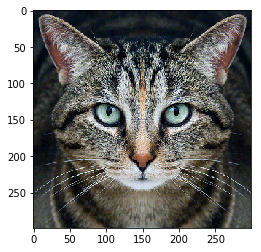

In [3]:
#Synthesizing Adversarial Examples

#load real image
img_path, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/cat.jpg')
img = Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)
plt.imshow(img)

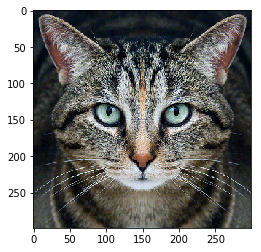

In [7]:
#generate adversarial samples
#initializer
x_hat = tf.Variable(tf.zeros((299, 299, 3)))
x = tf.placeholder(tf.float32, (299, 299, 3))
assign_op = tf.assign(x_hat, x)
sess.run(assign_op, feed_dict={x: img})
#make small perturbation
demo_epsilon = 2.0/255.0 
epsilon = tf.placeholder(tf.float32, ())
below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)
x_hat_ad = sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
plt.imshow(x_hat_ad)